# Introduction

This is just a no-stakes exploratory endeavour for the purpose of simply going through the standard processes of a data science project and understanding the purpose and methods of each one. 

I'm also approaching this as a complete novice in the subject matter (which is the truth) and looking at the features from a mostly quantitative perspective, at least until after I have ascertained that the value of the feature relies on domain knowledge.

In [25]:
# -- Load libraries --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from scipy import stats

In [33]:
# -- Setup --
# Seaborn settings
sns.set() 

# User-defined functions
def anova(df, varname):
    '''
    Function to streamline one-way ANOVA of categorical features
    '''
    vals = list()
    df.fillna('missing', inplace=True)
    for cat in df[varname].unique().tolist():
        vals.append(
            df.loc[df[varname] == cat, 'SalePrice_log'].values.tolist())
    f_value, p_value = stats.f_oneway(*vals)

    return f_value, p_value

def label_encode(var, values):
    '''
    Function to streamline label encoding ordinal features. 
    'values' argument must be list of labels in ascending order.
    '''
    le = preprocessing.LabelEncoder()
    le.fit(values)
    var_encoded = le.transform(var)

    return var_encoded

# Data folder
data_dir = './data/'

# Read input files
train = pd.read_csv(data_dir + 'train.csv')
# ----


81 columns total, quite a few consisting mostly missing values.

In [8]:
# -- Spelunking --
# Summary stats
train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check viability of columns with missing values.
Tempting to discard them but they could still hold valuable information.

In [34]:
# Count NA
na_count = train.isnull().sum().sort_values(ascending=False)
na_pct = (train.isnull().sum() / train.isnull().count() *
          100).sort_values(ascending=False)
missing = pd.concat([na_count, na_pct], axis=1, keys=['Total', '%'])
missing.head(20)

,Total,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Assess the preliminary viability of each feature by looking at the statistical significance.
First, the target feature must meet the 3 assumptions:
    1. Samples are independent
    2. Samples are from a normall distributed population
    3. Population standard deviations are equal

c:\users\gary_ng\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


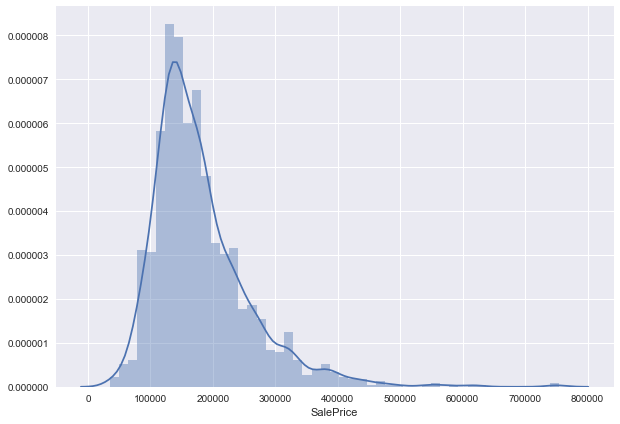

In [10]:
# Target Feature
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
sns.distplot(train['SalePrice'])

In [ ]:
Nope.
Log-transform to make it normal.

c:\users\gary_ng\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\gary_ng\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


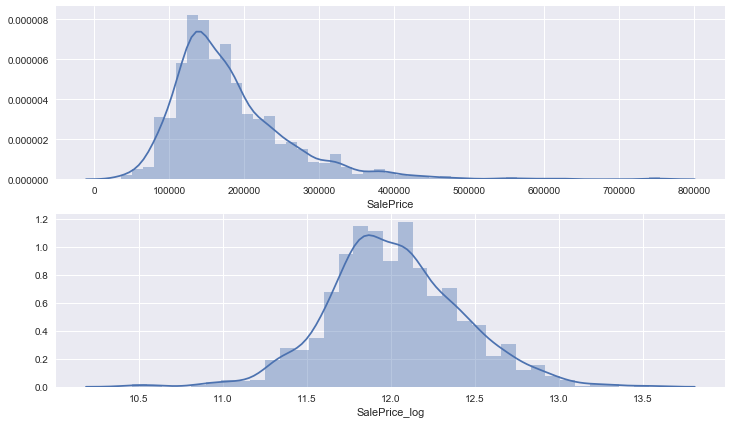

In [35]:
# Log-transform target feature
train['SalePrice_log'] = np.where(train['SalePrice'] <= 0, train['SalePrice'],
                                  np.log(train['SalePrice']))
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
sns.distplot(train['SalePrice'], ax=ax[0])
sns.distplot(train['SalePrice_log'], ax=ax[1])

In [36]:
print('D\'Agostino-Pearson Test\n{}'.format(
    '-' * 10))
s, p_value = stats.normaltest(train['SalePrice'])
print('SalePrice \t Stat: {},\tp-value: {}'.format(s, p_value))
s, p_value = stats.normaltest(train['SalePrice_log'])
print('SalePrice_log \t Stat: {},\tp-value: {}'.format(s, p_value))

D'Agostino-Pearson Test
----------
SalePrice 	 Stat: 610.8359109472653,	p-value: 2.283848353787728e-133
SalePrice_log 	 Stat: 25.507009834238303,	p-value: 2.89216582205235e-06


yep. 

Test for normality isn't great, but it is a marked improvement.

look at viability of numeric features using correlations

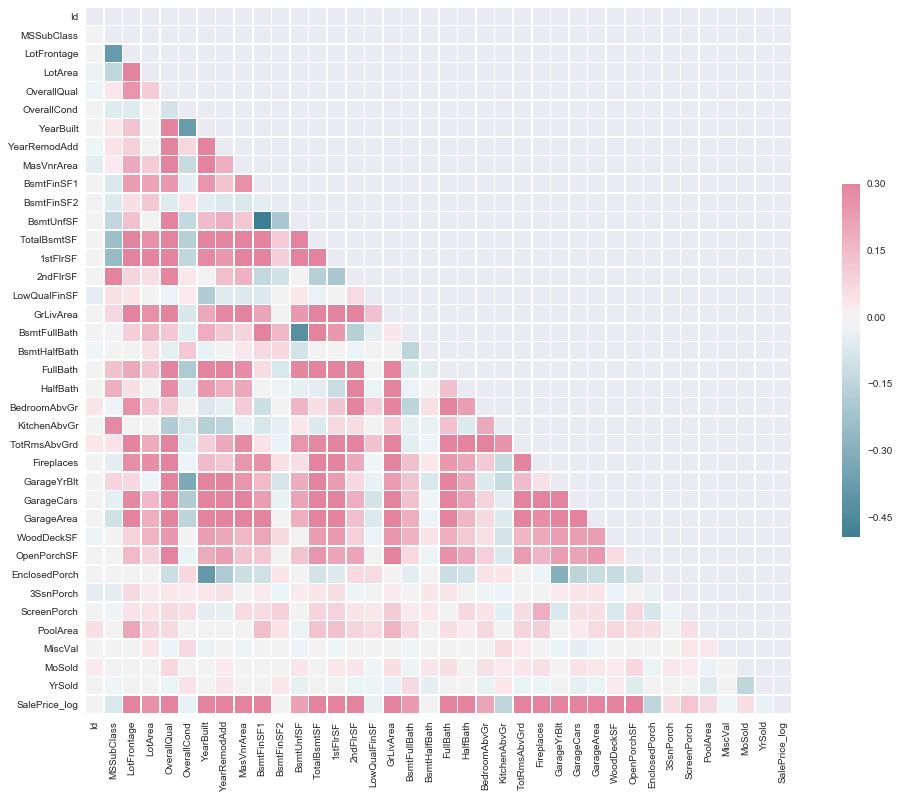

Correlation with 'SalePrice_log':
SalePrice_log    1.000000
OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355878
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
Encl

In [20]:
#  Correlations
corr = train.drop(labels='SalePrice', axis=1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 13))
cmap = sns.diverging_palette(220, 1, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={'shrink': .5})
plt.show()
print('Correlation with \'SalePrice_log\':')
print(corr['SalePrice_log'].sort_values(ascending=False))

Assessing viability of categorical variables with ANOVA

In [30]:
# ANOVA of categorical variables
anova_output = pd.DataFrame(columns=['feature', 'f_value', 'p_value'])
for col in train.select_dtypes(include=['object']).columns.tolist():
    f_value, p_value = anova(train, col)
    anova_output = anova_output.append(
        {
            'feature': col,
            'f_value': f_value,
            'p_value': p_value
        },
        ignore_index=True)
print(
    anova_output.reindex(
        anova_output.p_value.sort_values(ascending=True).index))

          feature     f_value        p_value
8    Neighborhood   79.520424  4.043304e-243
18      ExterQual  415.303357  6.935425e-195
21       BsmtQual  300.392324  2.031282e-188
30    KitchenQual  393.320196  4.441486e-187
34   GarageFinish  298.769753  4.057458e-151
33     GarageType  121.796388  8.427845e-125
32    FireplaceQu  131.198459  6.963458e-115
20     Foundation  126.806748  1.350671e-111
27      HeatingQC  110.820436   1.614882e-82
24   BsmtFinType1   71.381758   4.321404e-78
17     MasVnrType   87.834528   6.536414e-67
0        MSZoning   77.607843   1.021343e-59
15    Exterior1st   22.892270   1.053128e-53
16    Exterior2nd   19.922006   2.429938e-49
36     GarageCond   49.379257   2.508058e-47
23   BsmtExposure   60.494587   2.590707e-47
35     GarageQual   47.873273   6.068406e-46
28     CentralAir  205.666987   9.855628e-44
42  SaleCondition   43.076712   1.689708e-41
41       SaleType   24.759990   5.497893e-36
37     PavedDrive   74.898153   1.090995e-31
12     Hou

Unsurprisingly, aggregate measurements of quality rank high on statistical significance, but neighbourhood still takes the cake. Location, Location, Location.

Now I just want to build an arbitrary model to set a benchmark. I'll just take the top 4 categorical features first since their practical significance is easier to interpret.


'neighborhood' has to be one-hot encoded, quality measures have to be label-encoded to encode ordinal relationship.